# 1

In [ ]:
!pip install segyio

# TVG FILTER

In [ ]:
import obspy
import numpy as np

# Cargar archivo SEG-Y
st = obspy.read('as3800.SGY', unpack_trace_headers=True)

# Obtener parámetros del archivo SEG-Y
fs = st[0].stats.sampling_rate
nsamples = st[0].stats.npts
distances = st[0].stats.segy.trace_header.distance_from_center_of_the_shotpoint

# Calcular ganancia para cada muestra
tvg = np.zeros(nsamples)
for i in range(1, nsamples):
    tvg[i] = tvg[i-1] + (distances[i]-distances[i-1])/1000.0 # Distancia en kilómetros
tvg = np.exp(-2.0*tvg)

# Aplicar TVG a la señal
for tr in st:
    tr.data = tr.data * tvg

# Guardar archivo con TVG aplicado
st.write("sub_bottom_profile_tvg.segy", format="SEGY")

In [ ]:
!pip install fatiando

In [ ]:
import fatiando
fatiando.test()

In [ ]:
"""
Seismic: plotting a seismic section from a SEGY

Uses ObsPy package for SEGY file reading
You can find instructions for installing Obspy at http://obspy.org/

"""
from fatiando.vis import mpl
from obspy.segy import segy
import urllib
import numpy as np

# fetch sample SEGY data, near-offset marmousi data
url = "http://dl.dropboxusercontent.com/" \
      "s/i287ci4ww3w7gdt/marmousi_nearoffset.segy"
urllib.urlretrieve(url, 'marmousi_nearoffset.segy')
# We'll use the ObsPy library to load the SEGY data"
segyfile = segy.readSEGY('marmousi_nearoffset.segy')
# turn ObsPy Stream in a matrix of traces
# first dimension time, second dimension traces
ntraces = len(segyfile.traces)
nsamples = len(segyfile.traces[0].data)
mtraces = np.zeros((nsamples, ntraces))
i = 0
for tr in segyfile.traces:
    mtraces[:, i] = tr.data[:]
    i += 1
# make plots
mpl.figure()
mpl.subplot(2, 1, 1)
mpl.ylabel('time (seconds)')
mpl.title("Seismic wiggle plot", fontsize=13, family='sans-serif',
          weight='bold')
# plot using wiggle
mpl.seismic_wiggle(mtraces, scale=10**-4)
mpl.subplot(2, 1, 2)
mpl.ylabel('time (seconds)')
mpl.title("Seismic image plot", fontsize=13, family='sans-serif',
          weight='bold')
# plot using image
mpl.seismic_image(mtraces, aspect='auto')
mpl.show()

# 2

In [1]:
!pip install segyio
!pip install pylops
!pip install segysak

  Using cached numpy-1.22.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached numpy-1.22.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
gempy 2.2.12 requires numpy==1.21.6, but you have numpy 1.22.4 which is incompatible.
gempy 2.2.12 requires pandas==1.3.4, but you have pandas 2.1.3 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops
import re
from segysak.segy import segy_header_scan
from IPython.display import display

In [3]:
#Scanning the headers
scan = segy_header_scan('as3800.SGY')
scan

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,2095.5,288.819436,1596.0,1845.75,2095.5,2345.25,2595.0
TRACE_SEQUENCE_FILE,5,1000.0,500.5,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,8.0,0.000000,8.0,8.00,8.0,8.00,8.0
TraceNumber,13,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,1000.0,274.5,72.204317,150.0,212.00,274.5,337.00,399.0
...,...,...,...,...,...,...,...,...,...
SourceMeasurementMantissa,225,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementUnit,231,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
UnassignedInt1,233,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0


In [4]:
with pd.option_context("display.max_rows", 89):
    display(scan)

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,2095.5,288.819436,1596.0,1845.75,2095.5,2345.25,2595.0
TRACE_SEQUENCE_FILE,5,1000.0,500.5,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,8.0,0.000000,8.0,8.00,8.0,8.00,8.0
TraceNumber,13,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,1000.0,274.5,72.204317,150.0,212.00,274.5,337.00,399.0
...,...,...,...,...,...,...,...,...,...
SourceMeasurementMantissa,225,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementUnit,231,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0
UnassignedInt1,233,1000.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0


In [ ]:
scan[scan["std"] > 0]

In [6]:
# Functions allow for the parsing of both text and traces headers into a dict and a pandas dataframe respectively.
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [7]:
filename = 'as3800.SGY'
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 19501, N Samples: 8001, Sample rate: 5.0ms'

In [ ]:
print(bin_headers)
print(trace_headers.columns)
print(text_headers)
print(trace_headers.head())

In [ ]:
#Plotting

In [8]:
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

'The 99th percentile is 3; the max amplitude is 19'

Text(0.5, 1.0, 'as3800.SGY')

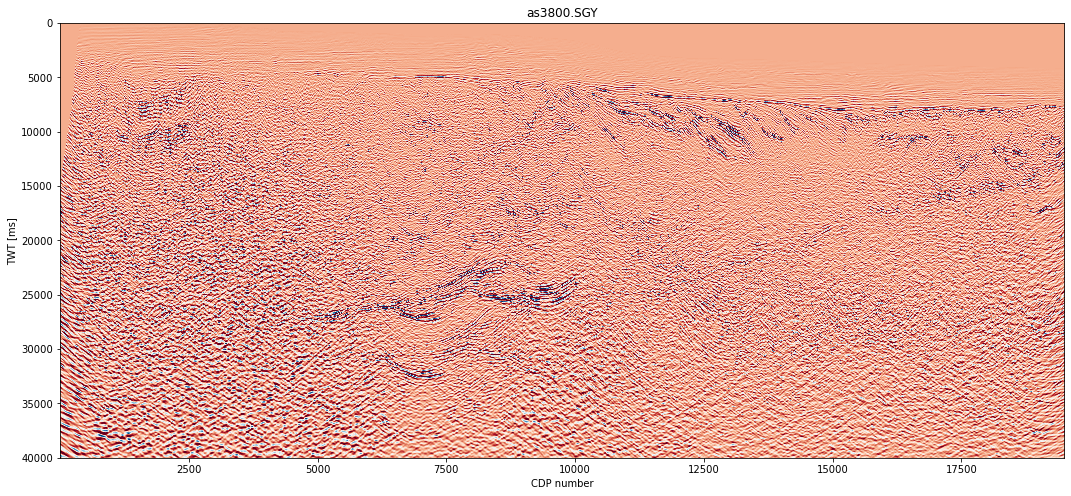

In [12]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-0, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'{filename}')

In [10]:
#Seismic inversion of data

segyfile = '...3d...'

f = segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent,
                xline=segyio.tracefield.TraceField.CDP)

il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape

plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight');

RuntimeError: unable to find sorting.Check iline, (223) and xline (21) in case you are sure the file is a 3D sorted volume

In [ ]:
# Get a quick estimate of the wavelet
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., :500], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

In [ ]:
# swap time axis to first dimension
d_small = d[..., :500]
d_small = np.swapaxes(d_small, -1, 0)

m_relative, r_relative = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, epsI=1e-4,
                                            simultaneous=False)
m_relative_reg, r_relative_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, epsI=1e-4, epsR=1e0,
                                            **dict(iter_lim=10, show=2))
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

In [ ]:
#Display the residuals

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion - residuals')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_relative[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');